In [1]:
import os
import numpy as np

RNG = np.random.default_rng(2023)
HOME = os.getenv("HOME")

In [2]:
from dataloaders import LineReader

reader = LineReader(
    nlines=10000,
    fparams=f"{HOME}/Datasets/cell_migration/parameters.txt",
    fseries=[
        f"{HOME}/Datasets/cell_migration/dac.txt",
        f"{HOME}/Datasets/cell_migration/msd.txt"
    ]
)

In [3]:
from bayesflow.simulation import GenerativeModel, Prior, Simulator

prior = Prior(prior_fun=reader.sample_params, param_names=["ix", "A", "B", "C", "D", "E"])
simulator = Simulator(simulator_fun=reader.simulate_series)

prior_means, prior_stds = prior.estimate_means_and_stds()
model = GenerativeModel(prior, simulator, name="basic_covid_simulator")

_ = model(10)
# print(prior_means, prior_stds)

INFO:root:Performing 2 pilot runs with the basic_covid_simulator model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2, 79)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


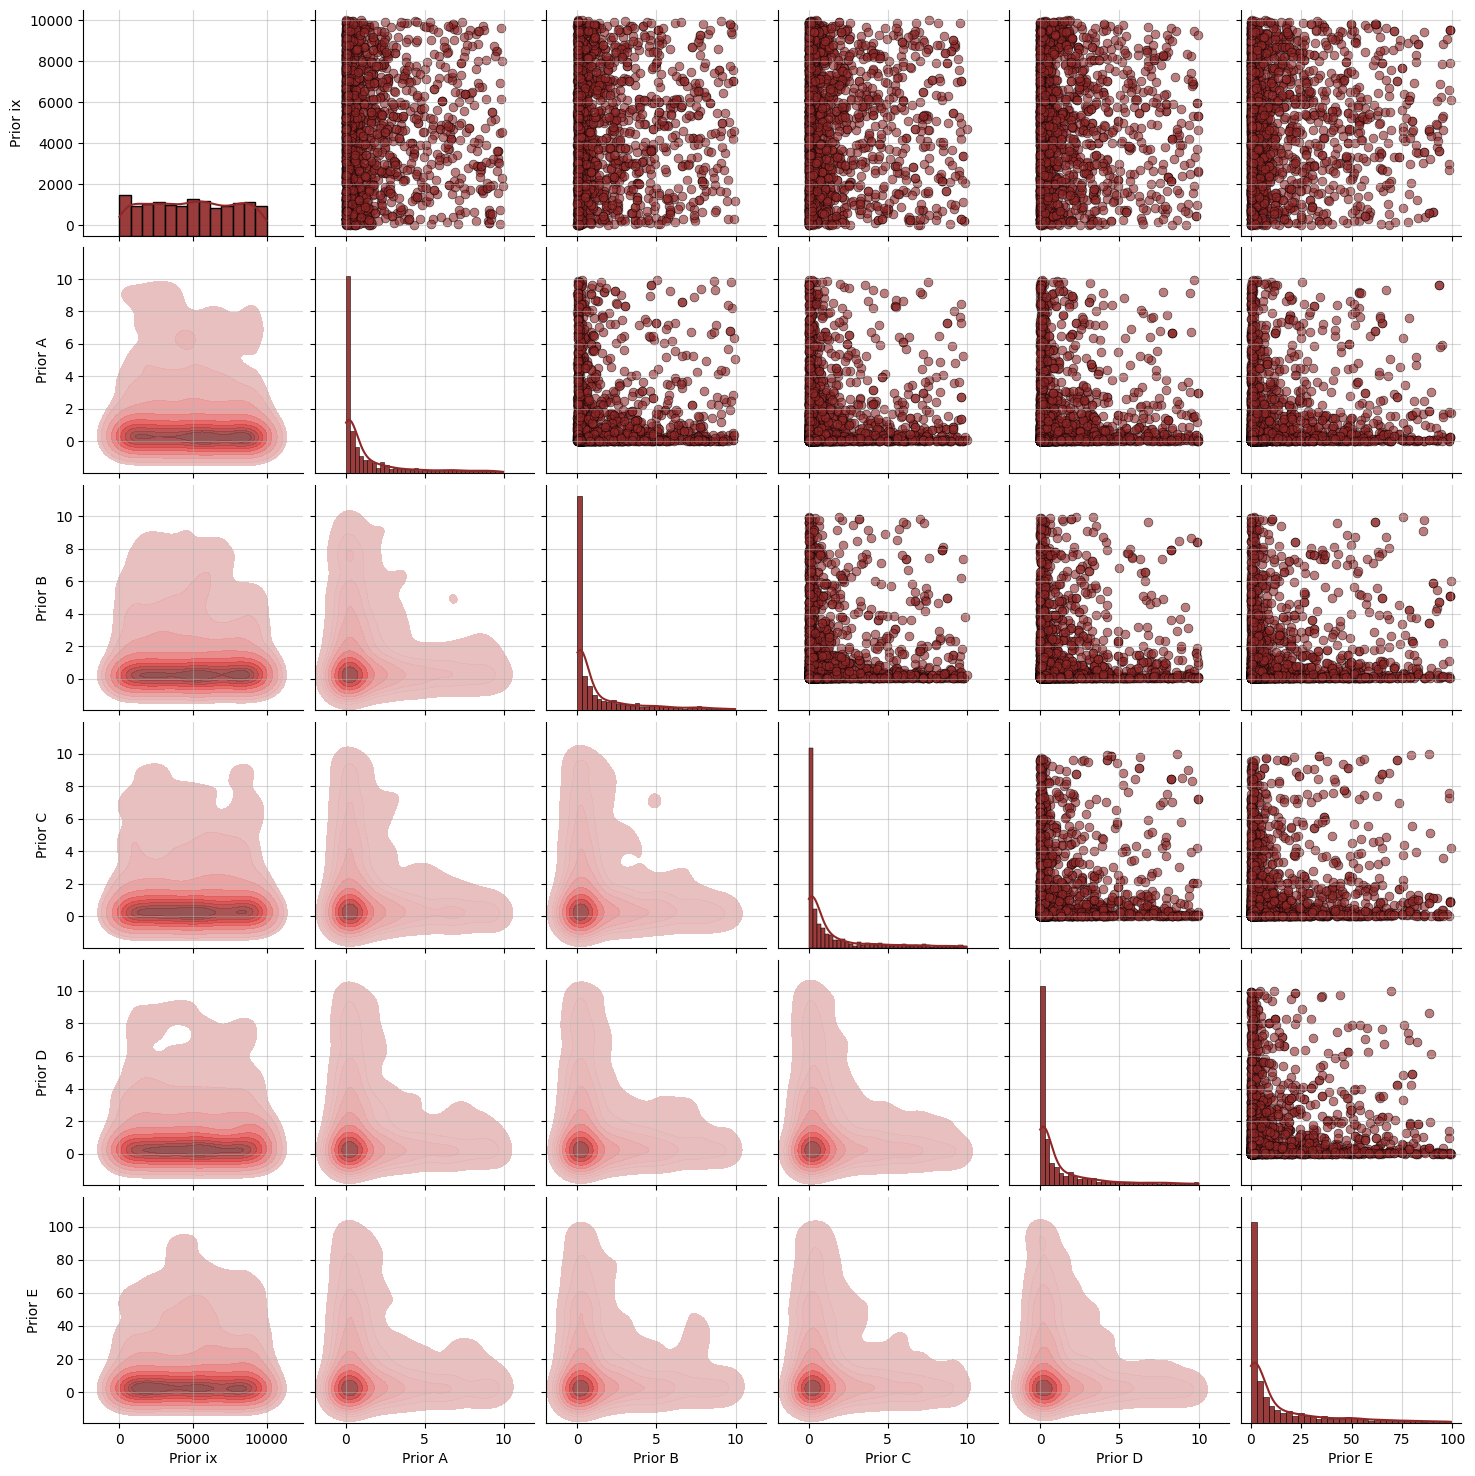

In [4]:
# As per default, the plot_prior2d function will obtain 1000 draws from the joint prior.
f = prior.plot_prior2d()

In [12]:
from bayesflow.networks import InvertibleNetwork, TimeSeriesTransformer
from bayesflow.amortizers import AmortizedPosterior

In [13]:
summary_net = TimeSeriesTransformer(input_dim=len(reader.series[0]))

In [14]:
inference_net = InvertibleNetwork(num_params=len(prior.param_names), num_coupling_layers=4)

In [15]:
amortizer = AmortizedPosterior(inference_net, summary_net, name="covid_amortizer")

In [16]:
from bayesflow.trainers import Trainer

def configure_input(forward_dict):
    """Function to configure the simulated quantities (i.e., simulator outputs)
    into a neural network-friendly (BayesFlow) format.
    """

    # Extract prior draws and z-standardize with previously computed means
    params = forward_dict["prior_draws"].astype(np.float32)
    params = (params - prior_means) / prior_stds
    
    # Convert data to logscale
    data = forward_dict["sim_data"].astype(np.float32)
    # data_mean = data.mean(axis=2)
    # data_std = data.std(axis=2)
    # print(data.shape)
    # print(data_mean.shape)
    # print(data_std)
    # data = (data - data_mean) / data_std
    # print(data)

    # Remove a batch if it contains nan, inf or -inf
    # idx_keep = np.all(np.isfinite(data), axis=(1, 2))
    # if not np.all(idx_keep):
    #     print("Invalid value encountered...removing from batch")

    return {
        "summary_conditions": data,
        "parameters": params
    }

trainer = Trainer(amortizer=amortizer, generative_model=model, configurator=configure_input, memory=True)

INFO:root:Performing a consistency check with provided components...


ConfigurationError: Could not carry out computations of generative_model ->configurator -> amortizer -> loss! Error trace:
 Exception encountered when calling layer 'multi_head_attention_block_6' (type MultiHeadAttentionBlock).

{{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [2,2,79] vs. [2,2,2] [Op:AddV2] name: 

Call arguments received by layer 'multi_head_attention_block_6' (type MultiHeadAttentionBlock):
  • x=tf.Tensor(shape=(2, 2, 79), dtype=float32)
  • y=tf.Tensor(shape=(2, 2, 79), dtype=float32)
  • kwargs={'training': 'None'}

In [151]:
amortizer.summary()

Model: "covid_amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network_3 (Inve  multiple                  299152    
 rtibleNetwork)                                                  
                                                                 
 sequence_network_1 (Sequen  multiple                  98666     
 ceNetwork)                                                      
                                                                 
Total params: 397818 (1.52 MB)
Trainable params: 397770 (1.52 MB)
Non-trainable params: 48 (192.00 Byte)
_________________________________________________________________


In [152]:
offline_data = model(10000)
history = trainer.train_offline(offline_data, epochs=30, batch_size=32, validation_sims=200)

INFO:root:Generated 200 simulations for validation.
Training epoch 1: 100%|██████████| 313/313 [00:09<00:00, 33.99it/s, Epoch: 1, Batch: 313,Loss: 8.721,W.Decay: 0.236,Avg.Loss: 8.814,Avg.W.Decay: 0.236,LR: 4.99E-04] 
INFO:root:Validation, Epoch: 1, Loss: 8.652
Training epoch 2: 100%|██████████| 313/313 [00:02<00:00, 150.31it/s, Epoch: 2, Batch: 313,Loss: 10.168,W.Decay: 0.236,Avg.Loss: 8.835,Avg.W.Decay: 0.236,LR: 4.95E-04]
INFO:root:Validation, Epoch: 2, Loss: 8.665
Training epoch 3: 100%|██████████| 313/313 [00:02<00:00, 145.04it/s, Epoch: 3, Batch: 313,Loss: 8.852,W.Decay: 0.236,Avg.Loss: 8.859,Avg.W.Decay: 0.236,LR: 4.88E-04] 
INFO:root:Validation, Epoch: 3, Loss: 8.700
Training epoch 4: 100%|██████████| 313/313 [00:02<00:00, 152.11it/s, Epoch: 4, Batch: 313,Loss: 8.452,W.Decay: 0.236,Avg.Loss: 8.867,Avg.W.Decay: 0.236,LR: 4.78E-04] 
INFO:root:Validation, Epoch: 4, Loss: 8.694
Training epoch 5: 100%|██████████| 313/313 [00:02<00:00, 145.53it/s, Epoch: 5, Batch: 313,Loss: 9.691,W.D

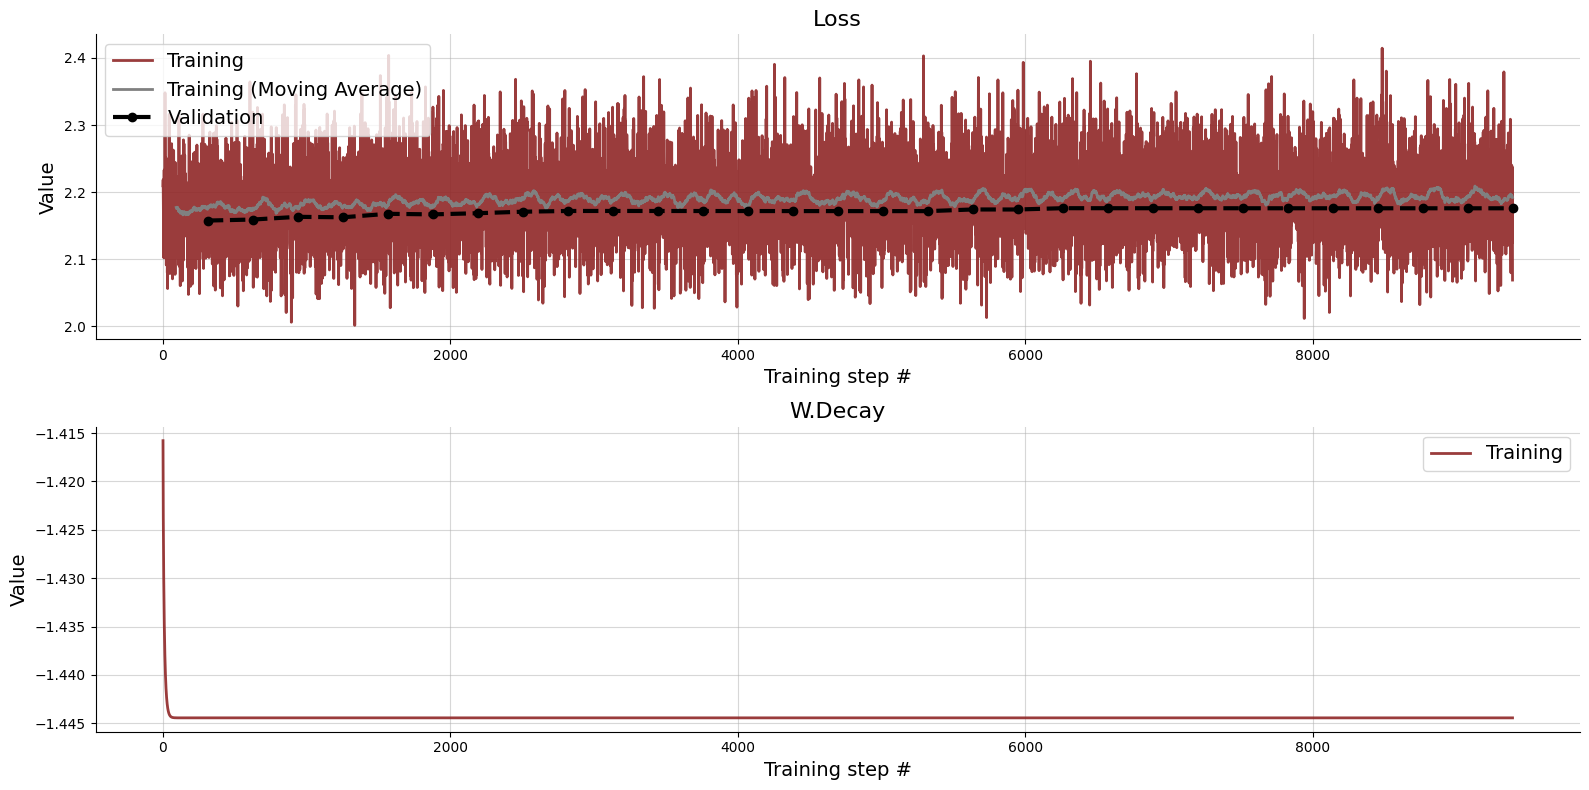

In [153]:
import bayesflow.diagnostics as diag

f = diag.plot_losses(np.log(history["train_losses"]), np.log(history["val_losses"]), moving_average=True)

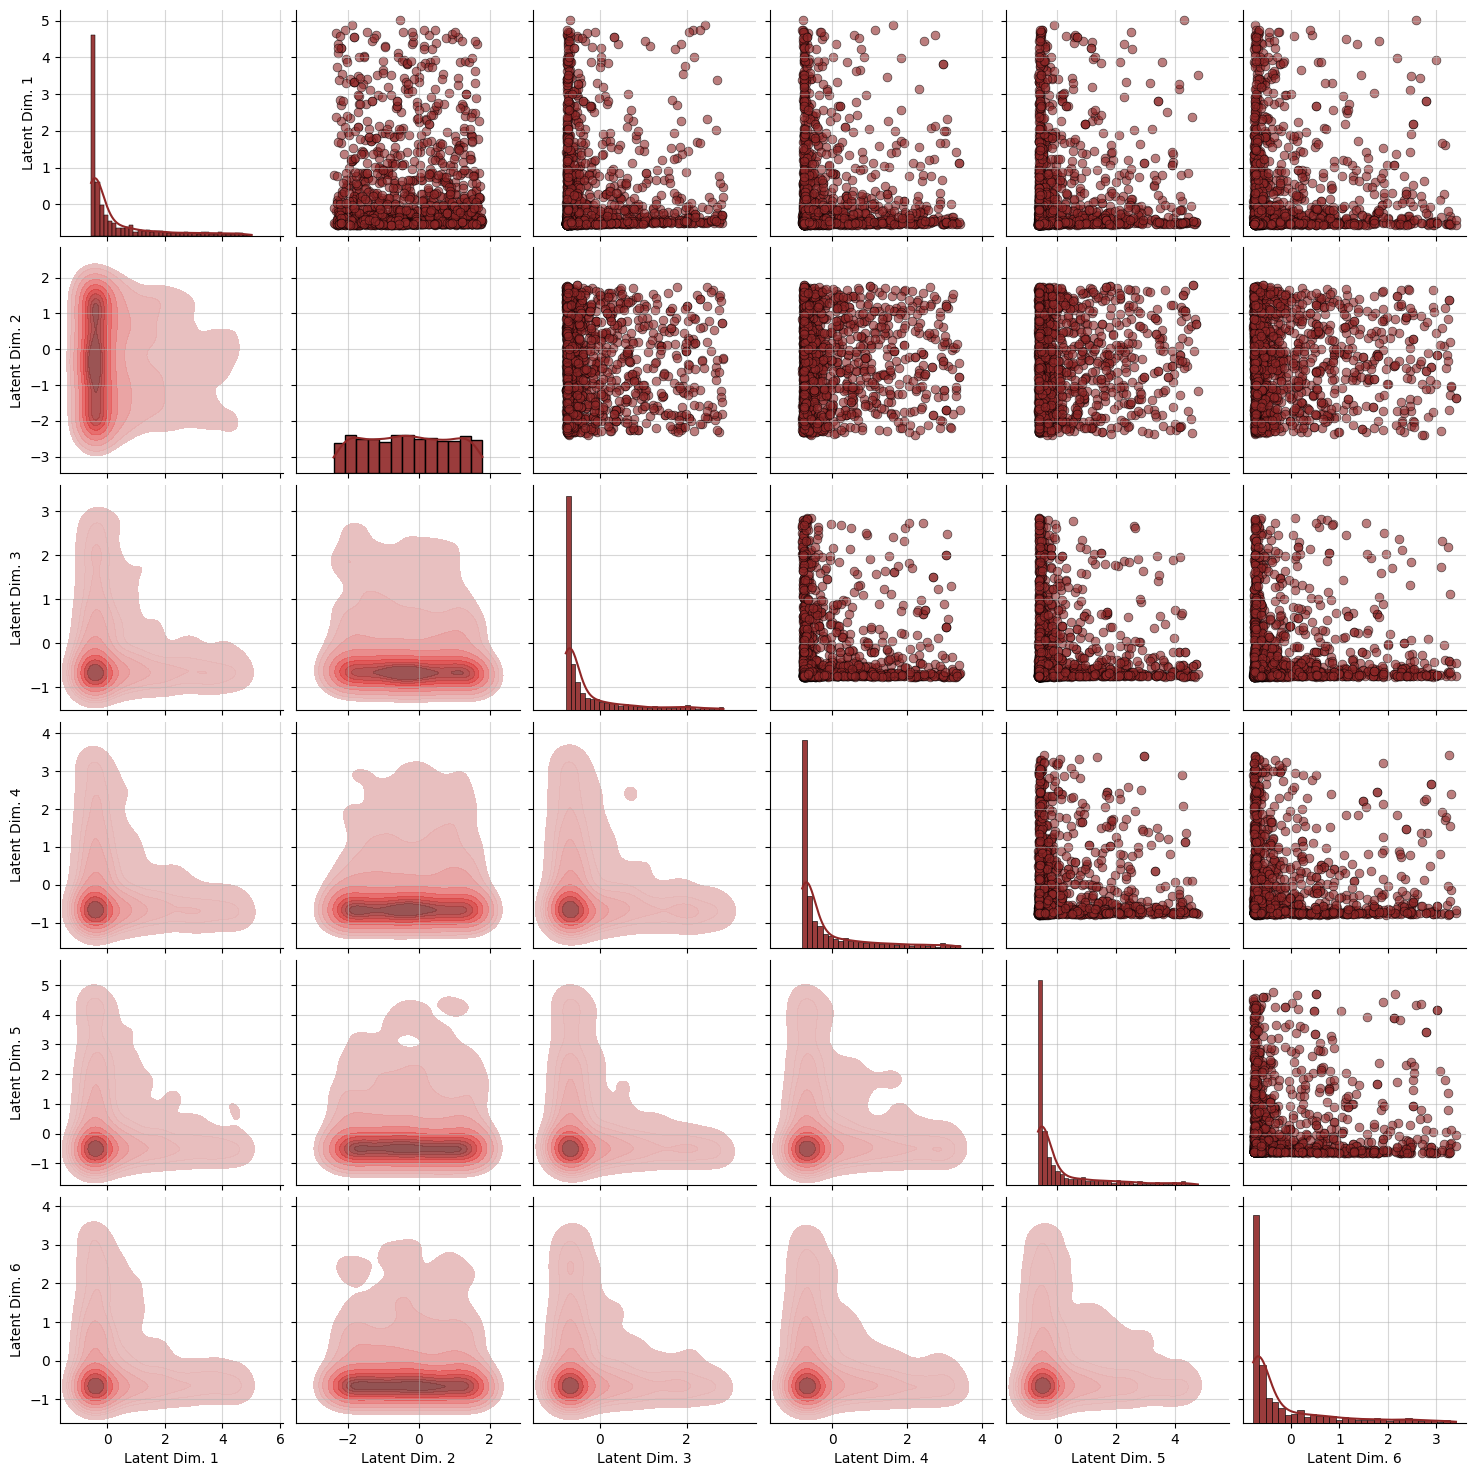

In [154]:
f = trainer.diagnose_latent2d()

In [155]:
# f = trainer.diagnose_sbc_histograms()

In [156]:
# Generate some validation data
validation_sims = trainer.configurator(model(batch_size=300))

# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=100)

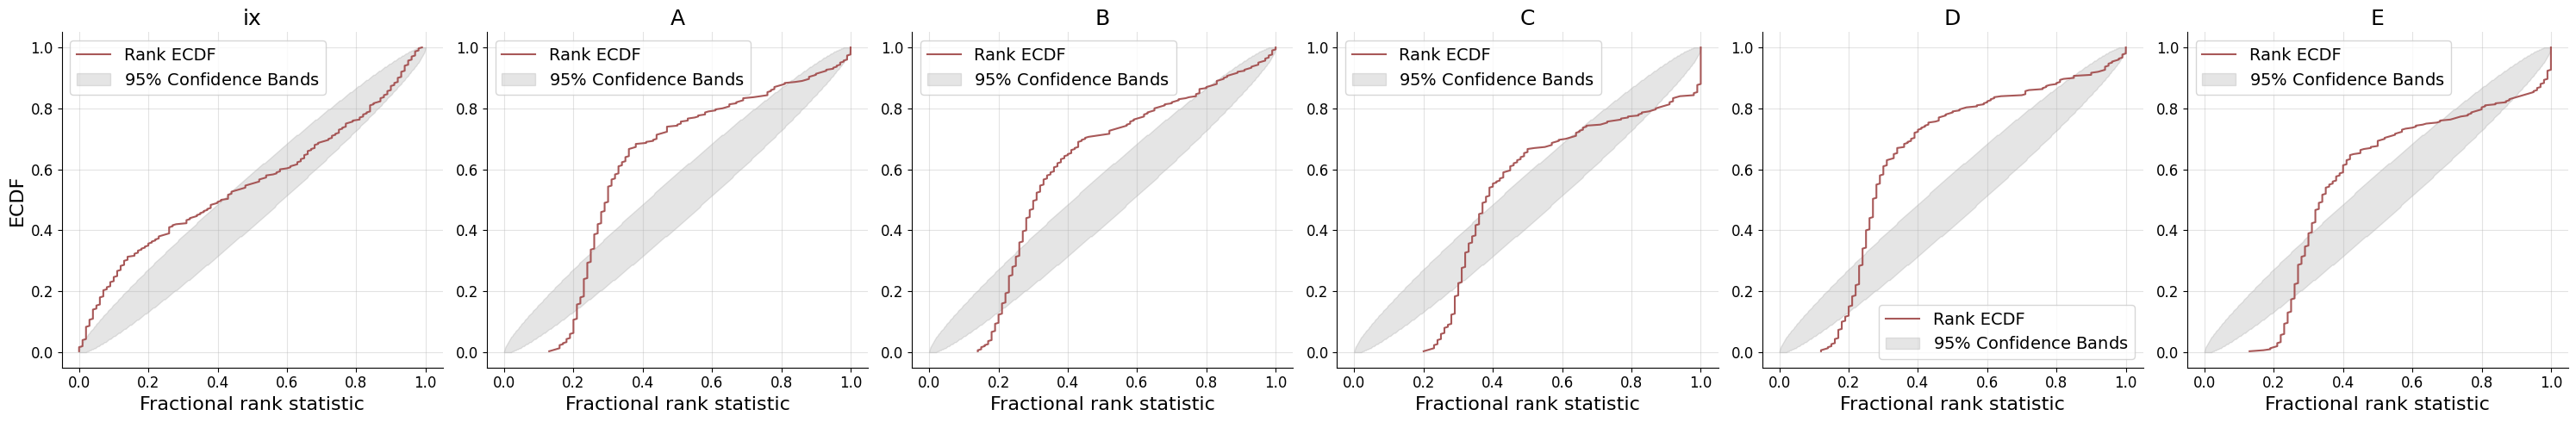

In [157]:
# Create ECDF plot
f = diag.plot_sbc_ecdf(post_samples, validation_sims["parameters"], param_names=prior.param_names)

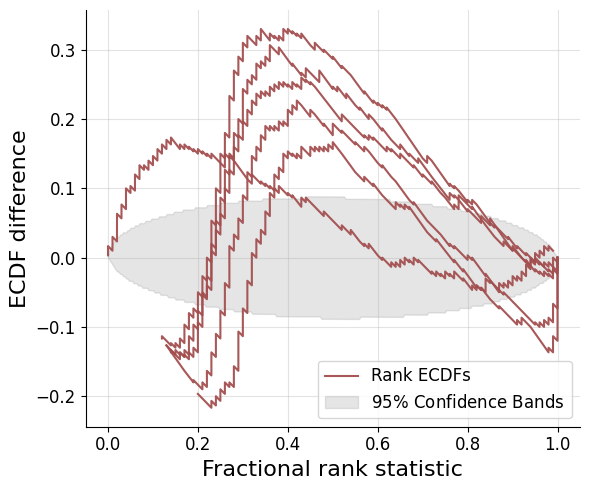

In [158]:
f = diag.plot_sbc_ecdf(
    post_samples, validation_sims["parameters"], stacked=True, difference=True, legend_fontsize=12, fig_size=(6, 5)
)

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 3.                    Confidence intervals might be unreliable!


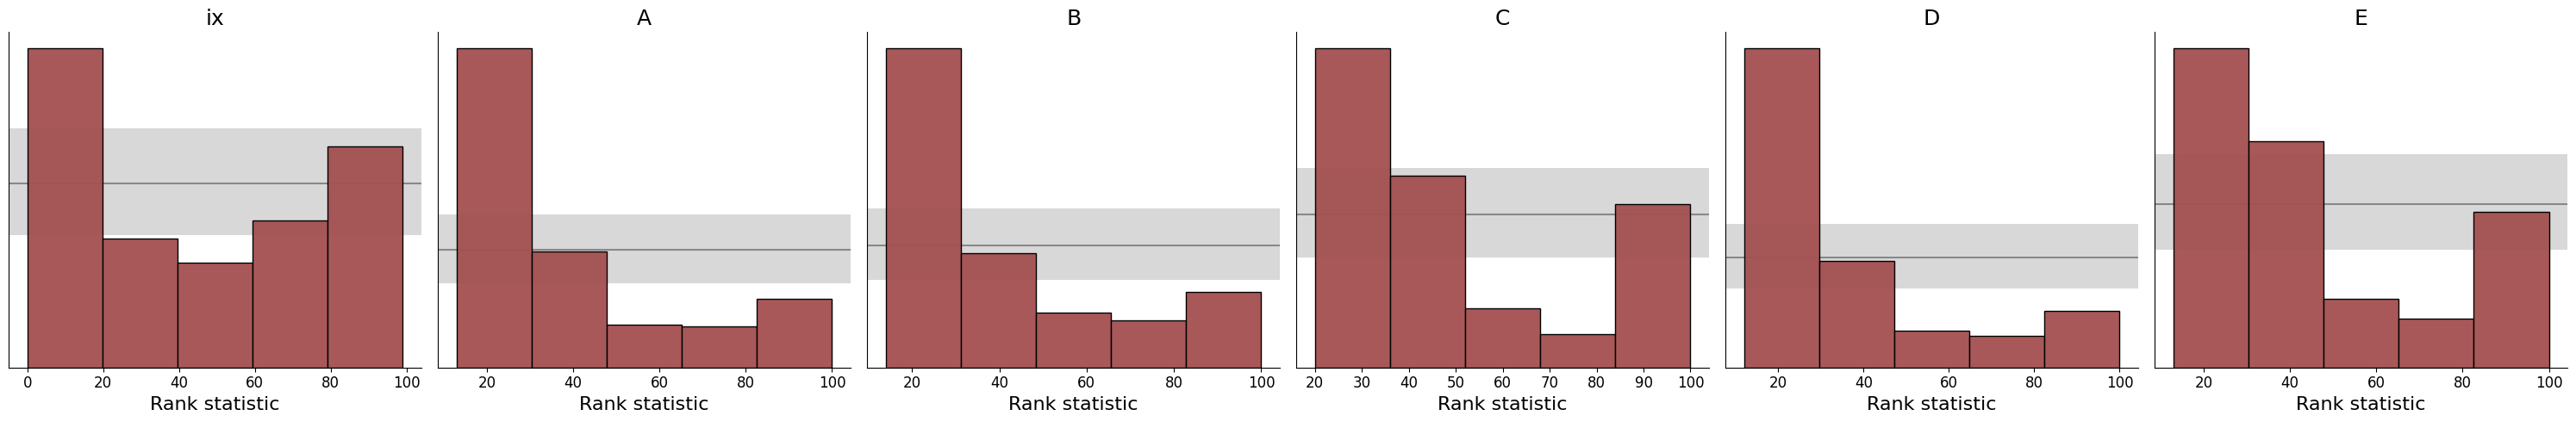

In [159]:
f = diag.plot_sbc_histograms(post_samples, validation_sims["parameters"], param_names=prior.param_names)

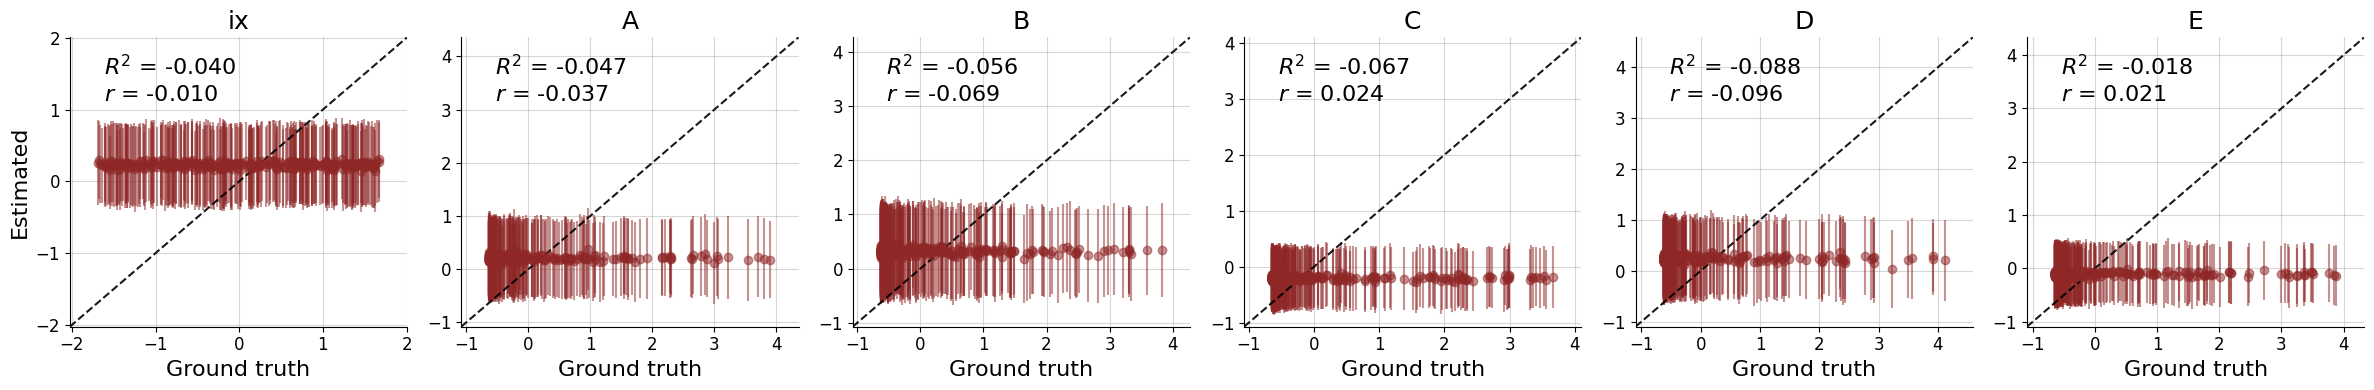

In [160]:
from diagnostics import plot_recovery

post_samples = amortizer.sample(validation_sims, n_samples=1000)
f = diag.plot_recovery(post_samples, validation_sims["parameters"], param_names=prior.param_names)

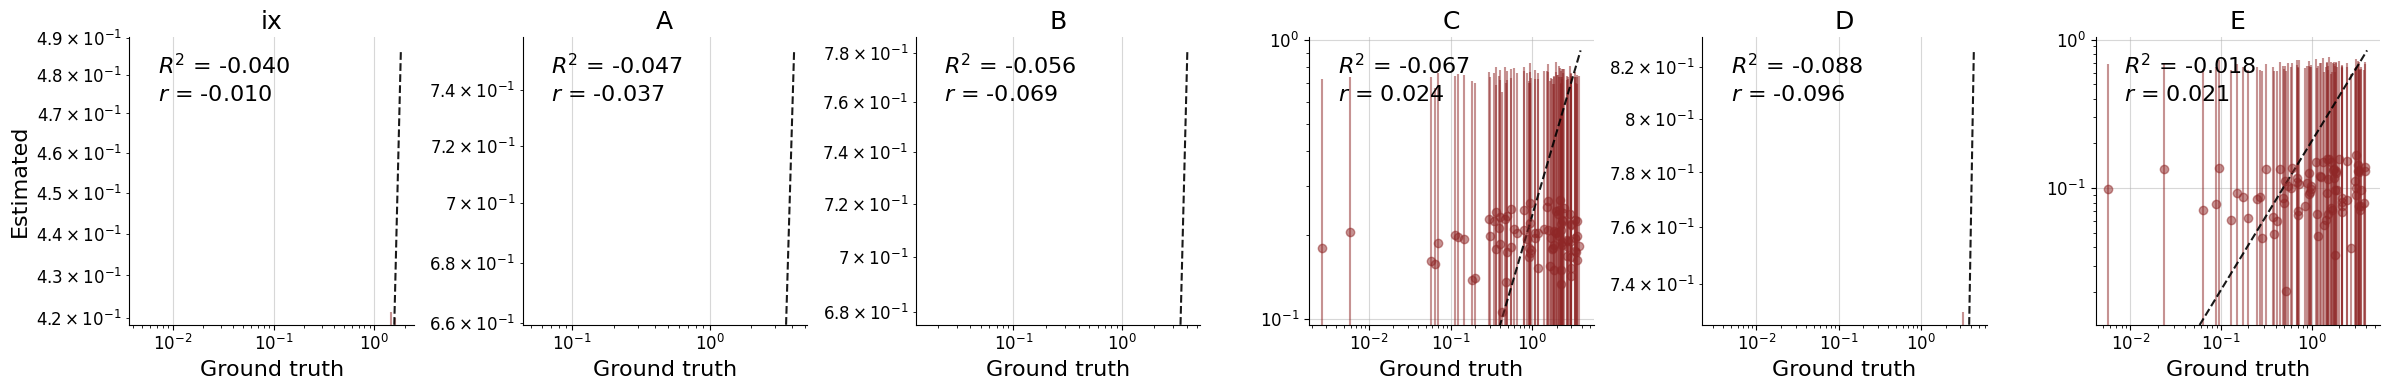

In [161]:
f = plot_recovery(post_samples, validation_sims["parameters"], param_names=prior.param_names)